# Detecting Cancer Metastases on Gigapixel Pathology Images

### Aim 
Develop a system to identify and locate tumor regions in Gigapixel tissue slides to assist pathologists for detection of cancer

### Dataset 
A subset of slides and their respective tumor masks from [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. The original slides and annotations have already been converted to a more easily usable TIF format. Every slide (and mask) file consists of images of varying zoom levels.

Reference paper - [Detecting Cancer Metastases on Gigapixel Pathology Images](https://arxiv.org/abs/1703.02442)

In [ ]:
# Setting the global constants

CREATE_DATA = False
TRAIN_MODEL = False
DOWNLOAD_SLIDES = False
PATCH_SIZE = 299
LEVEL = 1

In [ ]:
slide_dir = '/home/patni/DL_project/slides/'
project_folder = '/home/patni/DL_project'

In [ ]:
%matplotlib inline
import time
import os
import pathlib
import sklearn
import json
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from random import shuffle
from collections import Counter
from PIL import Image
from tensorflow import keras
from sklearn.metrics import confusion_matrix, f1_score
from skimage.color import rgb2gray
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from openslide import open_slide, __library_version__ as openslide_version

In [ ]:
slide_path = os.path.join(slide_dir, 'tumor_091.tif')
tumor_mask_path = os.path.join(slide_dir, 'tumor_091_mask.tif')

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /home/mp3949/DL_project/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /home/mp3949/DL_project/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

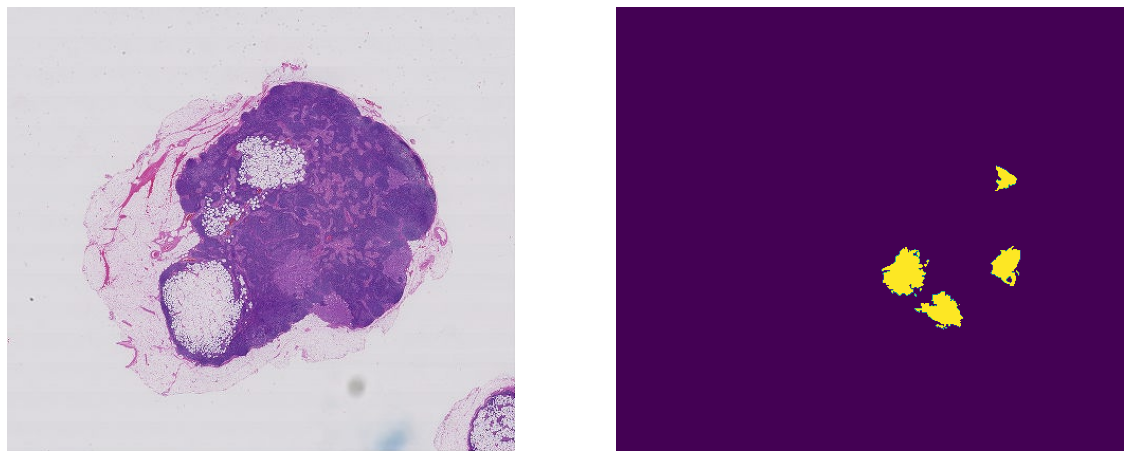

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])[:,:,0]

plt.figure(figsize=(20,20))
ax = plt.subplot(1,2,1)
plt.imshow(slide_image)
plt.axis('off')
ax = plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mask_image)

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# Calculate the percentage of tumor pixels in a given mask patch
def find_tumor_pixels(mask):
    indices = np.where(mask == 1)
    return round(100.0*len(indices[0]) / (mask.shape[0]*mask.shape[1]),2)

## Display available slides

We only consider the slides which have at least 0.5% of tumor pixels

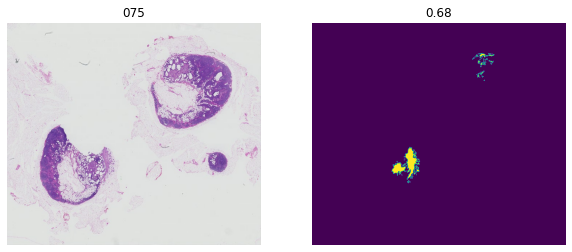

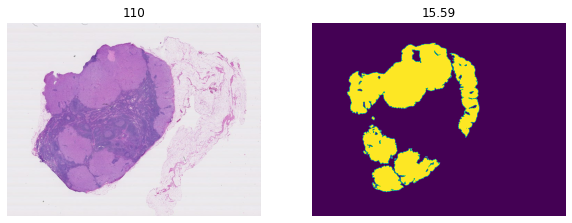

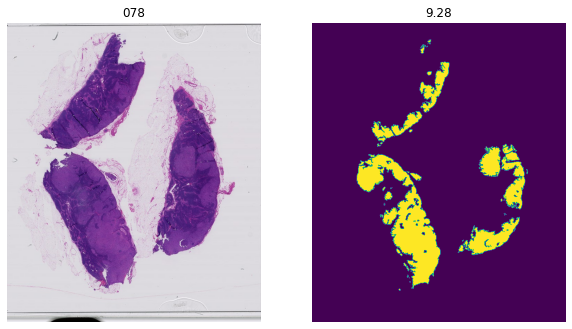

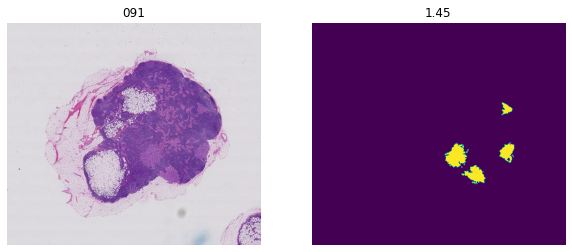

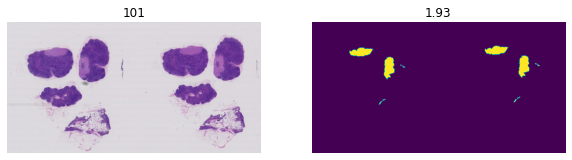

In [ ]:
def show_all_slides():
    slides = []
    for f in os.listdir(slide_dir):
        if 'tif' not in f:
            continue
        fname_split = f.split('.')[0].split('_')
        if len(fname_split) > 2:
            continue
        slide_no = fname_split[1]
        mask_f = '_'.join(fname_split) + '_mask.tif'
        if not os.path.exists(os.path.join(slide_dir, mask_f)):
            continue
        slide_f, mask_f = os.path.join(slide_dir, f), os.path.join(slide_dir, mask_f)
        slide = open_slide(slide_f)
        im = read_slide(slide, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])
        plt.figure(figsize=(10,10))
        ax = plt.subplot(1,2,1)
        plt.imshow(im)
        plt.axis('off')
        plt.title(slide_no)

        mask = open_slide(mask_f)
        im_mask = read_slide(mask, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])[:,:,0]
        ax = plt.subplot(1,2,2)
        plt.imshow(im_mask)
        tumor_pct = find_tumor_pixels(im_mask)
        plt.title(tumor_pct)
        plt.axis('off')
        slides.append([slide_no, os.path.join(slide_dir, f), os.path.join(slide_dir, mask_f), tumor_pct])
    return slides

slides = show_all_slides()

## Splitting into train, validation and test dataset

We maintain a CSV file with metadata of all the slides listed above. 
Randomly choose 2 slides for training and 1 for validation

In [ ]:
df = pd.read_csv(os.path.join(project_folder, 'slide_data.csv'))
train_slides = [75,78]
val_slides = [91]

train_df = df[df.slide_no.isin(train_slides)]
val_df = df[df.slide_no.isin(val_slides)]
test_df = df[~df.slide_no.isin(train_slides)]
test_df = test_df[~test_df.slide_no.isin(val_slides)]

In [ ]:
def display_slides(slide_nos):
    for slide_no in slide_nos:
        slide_f = os.path.join(slide_dir, "tumor_{}.tif".format(str(slide_no).zfill(3)))
        mask_f = os.path.join(slide_dir, "tumor_{}_mask.tif".format(str(slide_no).zfill(3)))
        slide = open_slide(slide_f)
        im = read_slide(slide, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])
        plt.figure(figsize=(10,10))
        ax = plt.subplot(1,2,1)
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Slide {slide_no}")

        mask = open_slide(mask_f)
        im_mask = read_slide(mask, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])[:,:,0]
        ax = plt.subplot(1,2,2)
        plt.imshow(im_mask)
        tumor_pct = find_tumor_pixels(im_mask)
        plt.title(f"Mask with tumor pct {tumor_pct}")
        plt.axis('off')


In [ ]:
train_slides = [75,78]
val_slides = [91]

train_df = df[df.slide_no.isin(train_slides)]
val_df = df[df.slide_no.isin(val_slides)]
test_df = df[~df.slide_no.isin(train_slides)]
test_df = test_df[~test_df.slide_no.isin(val_slides)]

### Training slides

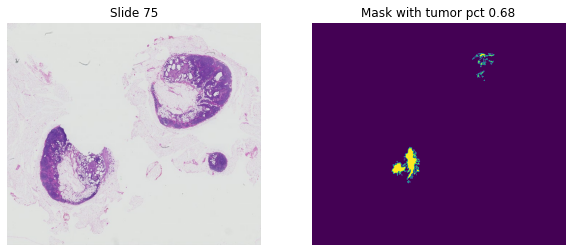

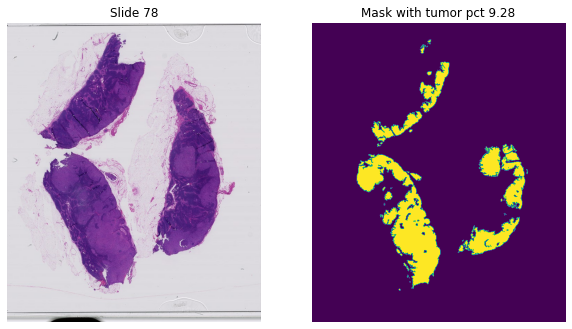

In [ ]:
display_slides(train_df['slide_no'])

### Validation slides

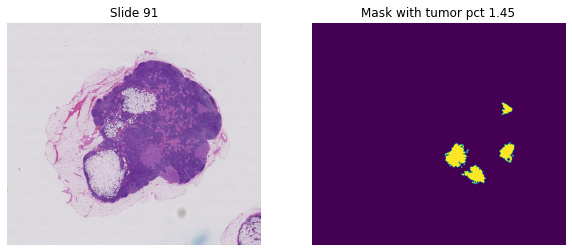

In [ ]:
display_slides(val_df['slide_no'])

## Generating patches

* We take a sliding window of (299x299) size and slide it throughout the slide at zoom level 1 to generate patches. 
* We disregard any patch which has less than `tissue_threshold` percent of tissue pixels using the provided `find_tissue_pixels` method in starter code.

Classify every patch into 2 categories - 
* `normal` - Patch does not contain tumor, i.e., less than `tumor_threshold` percent of pixels contain tumor as per the provided tumor mask
* `tumor` - Otherwise


In [ ]:
tissue_threshold = 2
tumor_threshold = 1

No. of patches 30


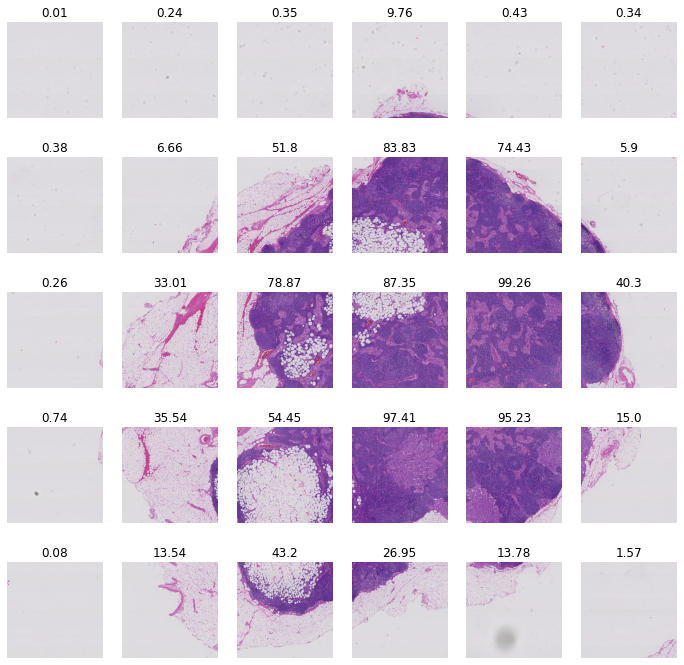

In [ ]:

level = 5
[width, height] = slide.level_dimensions[level]

fig, ax = plt.subplots(nrows=height//PATCH_SIZE, ncols=width//PATCH_SIZE, figsize=(12, 12))
print("No. of patches", (height//PATCH_SIZE) * (width//PATCH_SIZE))
row = 0
count = 0
for y in range(0, height-PATCH_SIZE, PATCH_SIZE):
    col = 0
    for x in range(0, width-PATCH_SIZE, PATCH_SIZE):
        im = read_slide(slide, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)
        tissue_pixels = find_tissue_pixels(im)
        percent_tissue = len(tissue_pixels) / float(PATCH_SIZE * PATCH_SIZE) * 100
        ax[row,col].axis('off')
        ax[row,col].imshow(im)
        ax[row,col].set_title(round(percent_tissue,2))
        col += 1
        count += 1
    row += 1
plt.show()

No. of patches 30


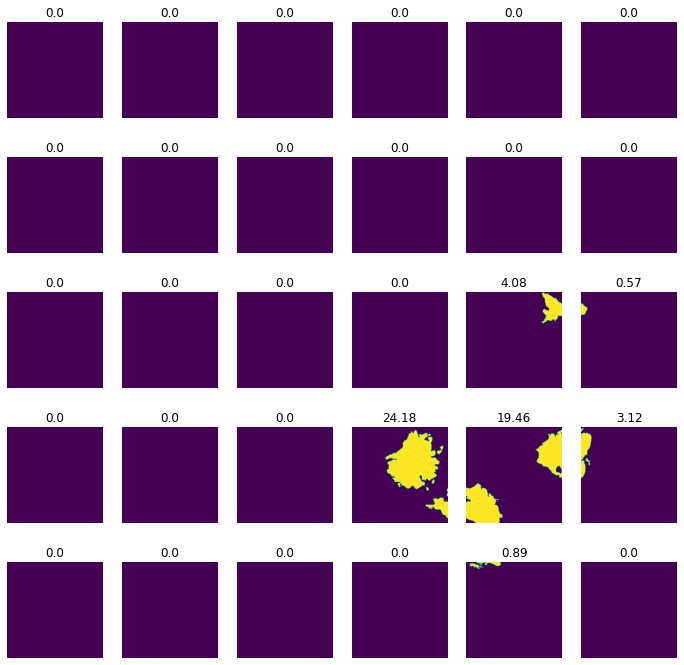

In [ ]:
level = 5
[width, height] = slide.level_dimensions[level]

fig, ax = plt.subplots(nrows=height//PATCH_SIZE, ncols=width//PATCH_SIZE, figsize=(12, 12))
print("No. of patches", (height//PATCH_SIZE) * (width//PATCH_SIZE))

count = 0
row = 0
for y in range(0, height-PATCH_SIZE, PATCH_SIZE):
    col = 0
    for x in range(0, width-PATCH_SIZE, PATCH_SIZE):
        im = read_slide(tumor_mask, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)[:,:,0]
        ax[row,col].axis('off')
        ax[row,col].imshow(im)
        ax[row,col].set_title(find_tumor_pixels(im))
        count += 1
        col += 1
    row += 1
plt.show()

## Saving training and validation data in form of patches

In [ ]:
data_dir = os.path.join(project_folder, "level_{}".format(LEVEL))
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
tumor_dir = os.path.join(train_dir, "tumor")
normal_dir = os.path.join(train_dir, "normal")
if not  os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
  
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

In [ ]:
def save_training_files(slide, tumor_mask, save_dir, slide_number, level=LEVEL):
    tumor_dir = os.path.join(save_dir, "tumor")
    normal_dir = os.path.join(save_dir, "normal")
    if not os.path.exists(tumor_dir):
        os.mkdir(tumor_dir)
    if not os.path.exists(normal_dir):
        os.mkdir(normal_dir)

    print("Extracting patches from slide", slide_number)
    [width, height] = slide.level_dimensions[level]
    print("No. of patches", (height//PATCH_SIZE) * (width//PATCH_SIZE))
    count = 0
    seen = 0
    start = time.time()
    for y in range(0, height-PATCH_SIZE, PATCH_SIZE):
        for x in range(0, width-PATCH_SIZE, PATCH_SIZE):
            seen += 1
            if seen % 1000 == 0:
                print("{} patches seen. Time taken - {}s".format(seen, time.time() - start))
            im = read_slide(slide, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)
            tissue_pixels = find_tissue_pixels(im)
            percent_tissue = len(tissue_pixels) / float(PATCH_SIZE * PATCH_SIZE) * 100
            if percent_tissue < tissue_threshold:
                continue
            mask = read_slide(tumor_mask, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)[:,:,0]
            tumor_pct = find_tumor_pixels(mask)
            dir = tumor_dir if tumor_pct > tumor_threshold else normal_dir
            im = Image.fromarray(im)
            im.save(os.path.join(dir, "{}_{}.PNG".format(slide_number, count)))
            count += 1
    print("Finished extracting patches from slide {}. Total {} patches extracted".format(slide_number, count))

In [ ]:
def create_save_patches(df, save_dir):
    for _,row in df.iterrows():
        slide_no = row['slide_no']
        slide_path = os.path.join(slide_dir, "tumor_{}.tif".format(str(slide_no).zfill(3)))
        mask_path = os.path.join(slide_dir, "tumor_{}_mask.tif".format(str(slide_no).zfill(3)))
        slide = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        save_training_files(slide, tumor_mask, save_dir, slide_no)

In [ ]:
if CREATE_DATA:
    create_save_patches(train_df, train_dir)
    create_save_patches(val_df, val_dir)

## Creating training and validation datasets using `image_dataset_from_directory`

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

data_dir = os.path.join(project_folder, "level_{}".format(LEVEL))
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=False
)

Found 23644 files belonging to 2 classes.
Found 3850 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
predictions = {}
labels = {}
lab_from_ds = list(val_ds.flat_map(lambda x,y: tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator())

## Utility methods
* To save and load models
* To plot evaluation metrics
* To generate heatmaps

In [ ]:
models = {}
histories = {}
linestyles = {}
linecolors = {}

In [ ]:
def save_model(model, model_name, level, epochs):
    model.save(os.path.join(project_folder, 'models/{}_{}_{}.h5'.format(model_name, LEVEL, EPOCHS)))
    
def load_model(model_name, level, epochs):
    return tf.keras.models.load_model(os.path.join(project_folder, 'models/{}_{}_{}.h5'.format(model_name, LEVEL, EPOCHS)))

In [ ]:
def save_history(history, level, epochs, model_name):
    file_name = os.path.join(project_folder, "histories/{}_{}_{}.json".format(model_name, level, epochs))
    json.dump(history, open(file_name, 'w'))

def load_history(level, epochs, model_name):
    file_name = os.path.join(project_folder, "histories/{}_{}_{}.json".format(model_name, level, epochs))
    return json.load(open(file_name, 'r'))

#### Plot metrics like Loss, Precision, Recall

In [ ]:
def plot_metrics(history, epochs):
    metrics = ['loss', 'prc', 'precision', 'recall']
    e = [i for i in range(epochs)]
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
        plt.subplot(2,2,n+1)
        plt.plot(e, history[metric], label='Train')
        plt.plot(e, history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
    plt.legend()

#### Plot confusion matrix

In [ ]:
def plot_cm(labels, predictions, title, p=0.5, print_out=True):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if print_out:
        print('True Negatives: ', cm[0][0])
        print('False Positives: ', cm[0][1])
        print('False Negatives: ', cm[1][0])
        print('True Positives: ', cm[1][1])
    save_dir = os.path.join(project_folder, "CM")
    plt.savefig(os.path.join(save_dir, f'{title}.PNG'))

#### Define method to generate heatmaps 

In [ ]:
def display_heatmap(df, model, level, model_name=None, multi_input=False, print_out=False):
    fig, ax = plt.subplots(nrows=df.shape[0], ncols=3, squeeze=False, figsize=(20, 20))
    i = 0
    save_dir = os.path.join(project_folder, "heatmaps")
    for _,row in df.iterrows():  
        slide_path = os.path.join(slide_dir, "tumor_{}.tif".format(str(row['slide_no']).zfill(3)))
        mask_path = os.path.join(slide_dir, "tumor_{}_mask.tif".format(str(row['slide_no']).zfill(3)))

        slide = open_slide(slide_path)
        slide_image = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
        ax[i,0].axis('off')
        ax[i,0].imshow(slide_image)
        ax[i,0].set_title('Slide')

        heatmap = create_heatmap(slide, level, model, multi_input, print_out)
        ax[i,1].axis('off')
        ax[i,1].imshow(heatmap)
        ax[i,1].set_title('Heatmap')
        if model_name is not None:
            matplotlib.image.imsave(os.path.join(save_dir, "{}.PNG".format(model_name)), heatmap)

        tumor_mask = open_slide(mask_path)
        mask_image = read_slide(tumor_mask, x=0, y=0, level=5, width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])[:,:,0]
        ax[i,2].axis('off')
        ax[i,2].imshow(mask_image)
        ax[i,2].set_title('True mask')
        i += 1
    plt.show()

In [ ]:
def create_heatmap(slide, level, model, multi_input=False, print_out=False):
    [width, height] = slide.level_dimensions[level]
    hm_size = [height//PATCH_SIZE, width//PATCH_SIZE]
    
    count = 0
    valid_patches = 0
    start = time.time()
    patches = []
    indices = []
    predictions = np.zeros(hm_size[0] * hm_size[1])
    for y in range(0, height-PATCH_SIZE, PATCH_SIZE):
        for x in range(0, width-PATCH_SIZE, PATCH_SIZE):
            if len(patches) == BATCH_SIZE:
                inp = np.array(patches)
                if multi_input:
                    preds = model.predict([inp[:,0,:,:], inp[:,1,:,:]])
                else:
                    preds = model.predict(inp)
                for i,pred in enumerate(preds):
                    predictions[indices[i]] = pred
                patches = []
                indices = []
            
            if count % 1000 == 0 and print_out:
                print("{} out of {} patches seen. Time taken - {}s".format(count, hm_size[0]*hm_size[1], time.time() - start))
            count += 1
            
            im = read_slide(slide, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)
            tissue_pixels = find_tissue_pixels(im)
            percent_tissue = len(tissue_pixels) / float(PATCH_SIZE * PATCH_SIZE) * 100
            if percent_tissue < tissue_threshold:
                continue
            
            if multi_input:
                (centre_x, centre_y) = (x+PATCH_SIZE//2, y+PATCH_SIZE//2)
                im2 = read_slide(slide, centre_x*(2**level) - (PATCH_SIZE//2)*2**(level+1), 
                                 centre_y*(2**level) - (PATCH_SIZE//2)*2**(level+1), level+1, PATCH_SIZE, PATCH_SIZE)
                patches.append([im,im2])
            else:
                patches.append(im)
            indices.append(count-1)
            valid_patches += 1

    predictions.resize(hm_size)
    return predictions

## Building classifiers

3 deep learning model architectures explored - 
1. Transfer learning using Inception V3 with imagenet weights.
2. A self-defined deep CNN with 4 stacked CNN and MaxPooling layers
3. Using multiple inputs - images at zoom level 1 and their corresponding zoomed out version at level 2 - Both images are parallelly passed through respective deep CNN layers (same as in the point above) and then output is concatenated followed by a Dense layer for binary prediction.

### 1. Transfer learning
Use weights from pre-trained Inception V3 model trained on imagenet. Add a `GlobalAveragePooling2D` layer on top followed by a dense layer. We track many metrics in the output related to binary classification.

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.MeanIoU(num_classes=2)
]

def create_model():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(299,299,3)) 
    base_model.trainable = False 
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(128, activation='relu')
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    model = tf.keras.Sequential()
    model.add(normalization_layer)
    model.add(base_model)
    model.add(global_average_layer)
    model.add( dense_layer)
    model.add(prediction_layer)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=METRICS)
    return model

In [ ]:
EPOCHS = 20
name = 'transfer_base'

if TRAIN_MODEL:
    model = create_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS).history
    save_model(model, name, LEVEL, EPOCHS)
    save_history(history, LEVEL, EPOCHS, name)
models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

In [ ]:
models[name].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


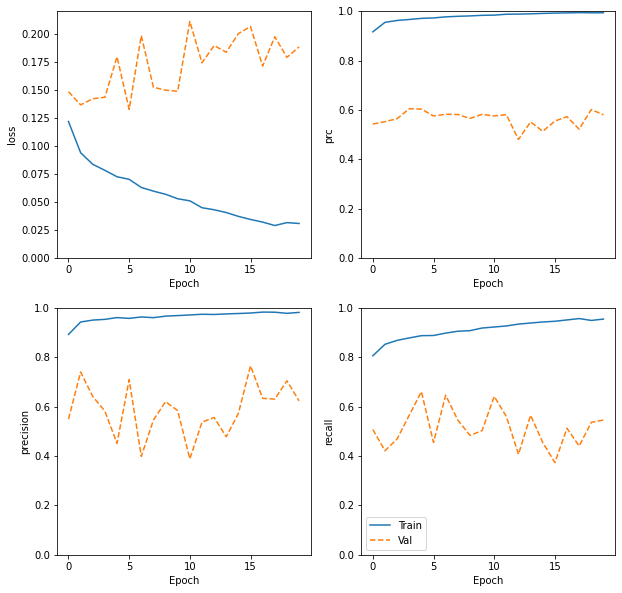

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3572
False Positives:  69
False Negatives:  95
True Positives:  114


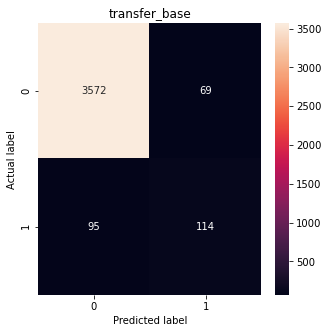

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'red'
linestyles[name] = '-'
plot_cm(labels[name], predictions[name], name)

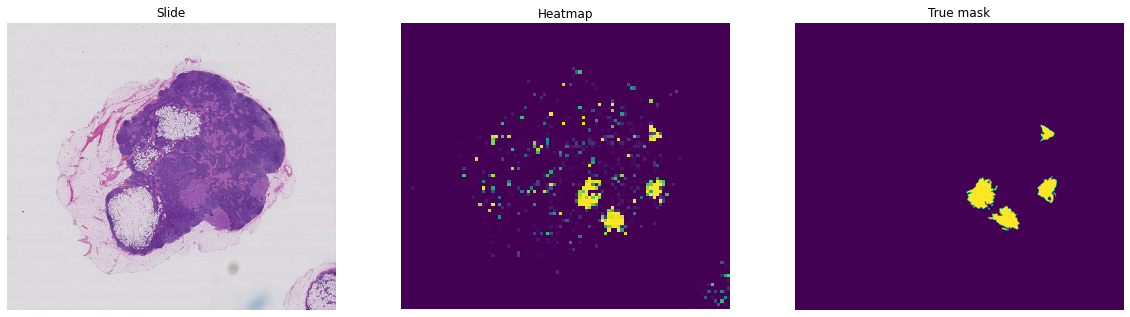

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

### Handling class imbalance

We observe that the tumor class is significantly under-represented in the data as compared to normal patches. We will try 2 different techniques to handle this and see whether it helps in creating better heatmaps.

#### Using class weights
We can specify `class_weight` in `model.fit()` in order to tell the model to "pay more attention" to samples from the under-represented `tumor` class. To calculate these weights, we use the example provided in [this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights).

Formula to calculate weights - 

Weight (tumor) = 1/2 * (Total / Count(tumor))

Weight (normal) = 1/2 * (Total / Count(normal))


In [ ]:
EPOCHS = 20
name = 'transfer_weighted'

if TRAIN_MODEL:
    train_labels = list(train_ds.flat_map(lambda x,y: tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator())
    ctr = Counter(train_labels)
    normal_count = ctr[0]
    tumor_count = ctr[1]
    total = tumor_count + normal_count
    class_weight = {0: (1.0/normal_count) * (total/2.0) , 1: (1.0/tumor_count) * (total/2.0)}    
    print(class_weight)
    model = create_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weight).history
    save_model(model, name, LEVEL, EPOCHS)
    save_history(history, LEVEL, EPOCHS, name)

models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

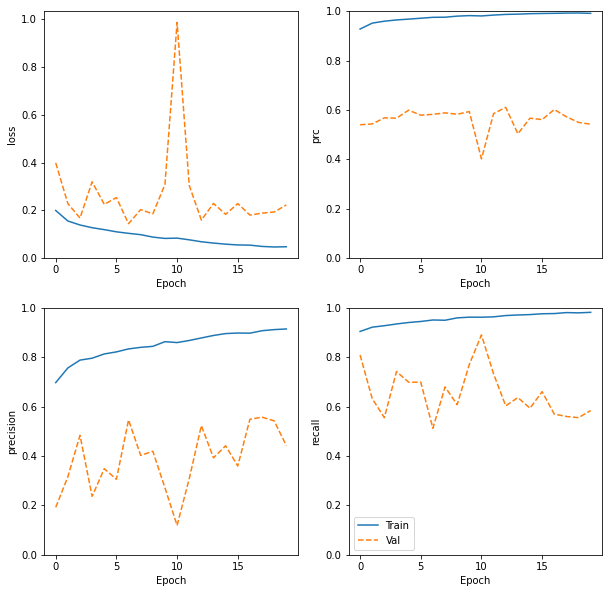

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3487
False Positives:  154
False Negatives:  87
True Positives:  122


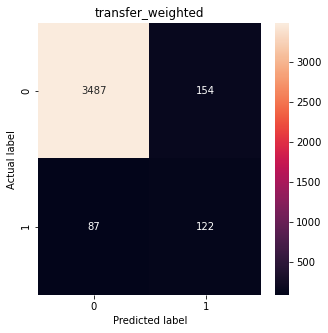

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'red'
linestyles[name] = 'dotted'
plot_cm(labels[name], predictions[name], name)

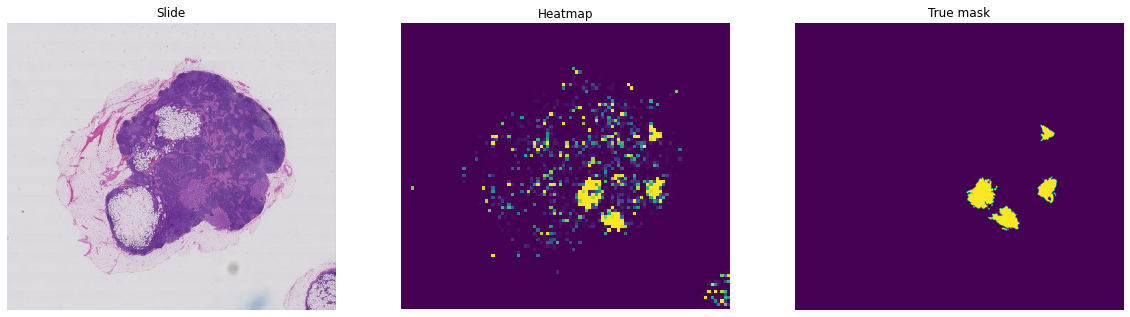

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

#### Upsampling the under-represented class
In this approach, we it upsampling on the `tumor` class. The way we do it is by creating a repeating dataset that gives out never-ending stream of batches of data. Then, we use `tf.data.experimental.sample_from_datasets` API and its `weights` parameter  which gives us batches of data with an equal weightage of `normal` and `tumor` patches.

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [PATCH_SIZE, ghPATCH_SIZE])
  return img

In [ ]:
def create_dataset(folder_path, label):
    paths = list(pathlib.Path(folder_path).glob('*'))
    paths = [str(path) for path in paths]
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast([label]*len(paths), tf.int64))
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
    ds = image_label_ds.shuffle(BUFFER_SIZE).repeat()
    return ds

In [ ]:
normal_ds = create_dataset(normal_dir, 0)
tumor_ds = create_dataset(tumor_dir, 1)
resampled_ds = tf.data.experimental.sample_from_datasets([normal_ds, tumor_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.shape)
  print(label.numpy().mean())

(32,)
0.59375


In [ ]:
EPOCHS = 10
name = 'transfer_resampled'

if TRAIN_MODEL:
    resampled_steps_per_epoch = np.ceil(2.0*normal_count/BATCH_SIZE)
    print("Resampled steps per epoch {}".format(resampled_steps_per_epoch))
    resampled_model = create_model()
    history_resampled = resampled_model.fit(resampled_ds, validation_data=val_ds, epochs=EPOCHS, 
                                            steps_per_epoch=resampled_steps_per_epoch).history
    now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    save_model(resampled_model, name, LEVEL, EPOCHS)
    save_history(history_resampled, LEVEL, EPOCHS, name)

models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

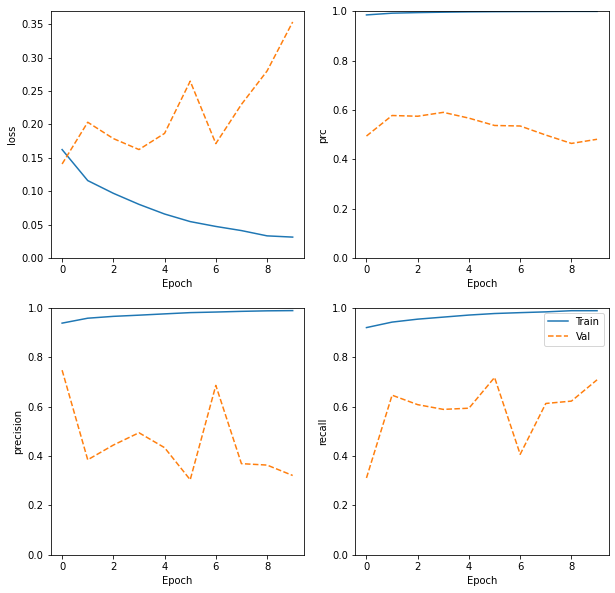

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3328
False Positives:  313
False Negatives:  61
True Positives:  148


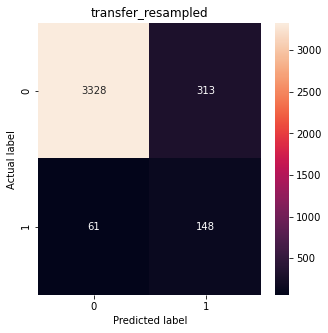

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'red'
linestyles[name] = '--'
plot_cm(labels[name], predictions[name], name)

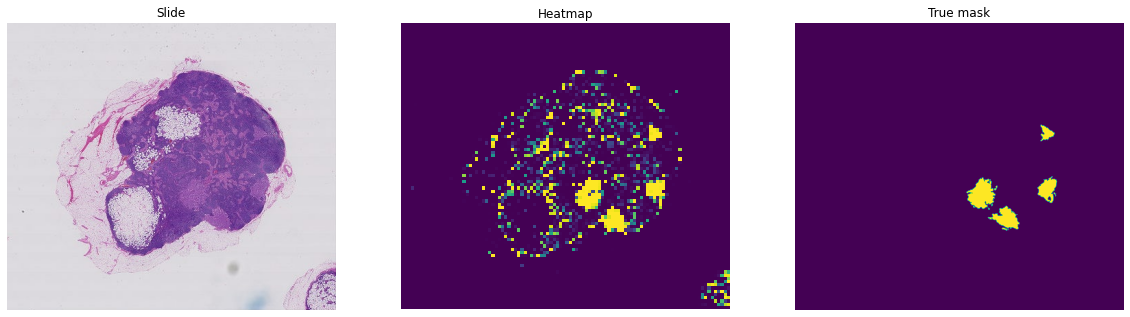

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

### Deep CNN model
Next, we use a basic deep CNN model with 4 stacked `Conv2D` with `MaxPooling2D` layers followed by a Dense layer. We also add a Dropout layer to avoid overfitting before a single-unit Dense layer for binary classification.

In [ ]:
def make_base_model():
    model_base = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    model_base.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=METRICS)
    return model_base

In [ ]:
EPOCHS = 20
name = 'cnn_base'

if TRAIN_MODEL:
    model = make_base_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS).history
    save_model(model, name, LEVEL, EPOCHS)
    save_history(history, LEVEL, EPOCHS, name)
models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

In [ ]:
models[name].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0

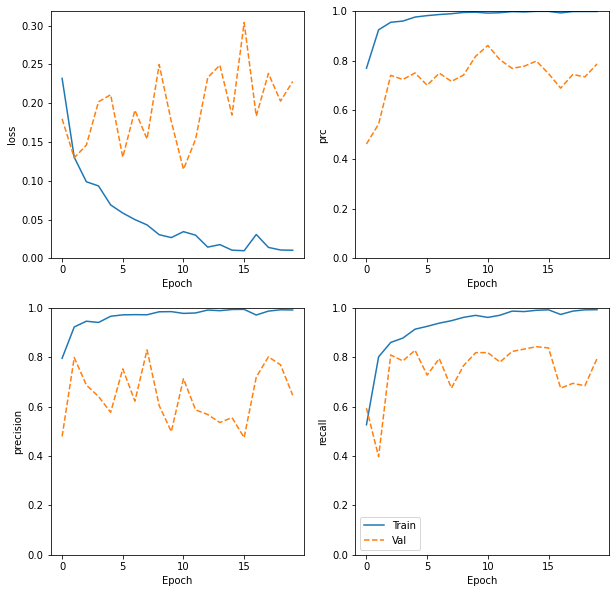

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3550
False Positives:  91
False Negatives:  43
True Positives:  166


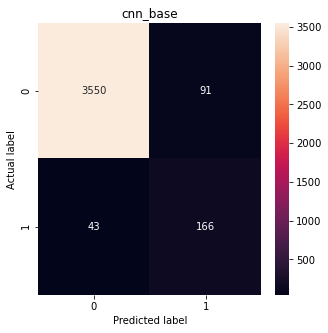

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'blue'
linestyles[name] = '-'
plot_cm(labels[name], predictions[name], name)

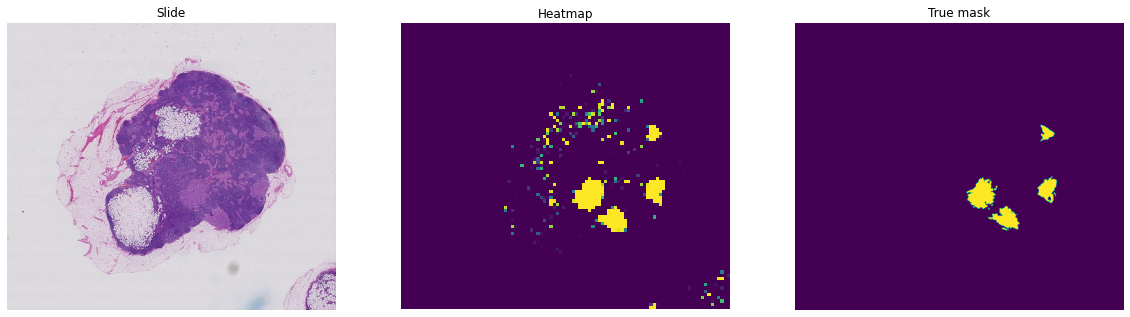

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

#### Using class weights

In [ ]:
EPOCHS = 20
name = 'cnn_weighted'

if TRAIN_MODEL:
    model_base = make_base_model()
    total = tumor_count + normal_count
    class_weight = {0: (1.0/normal_count) * (total/2.0) , 1: (1.0/tumor_count) * (total/2.0)}  
    print("Class weights: {}".format(class_weight))
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc', patience=10, restore_best_weights=True)
    history_base = model_base.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, 
                                  class_weight=class_weight, callbacks=[callback]).history
    save_model(model_base, name, LEVEL, EPOCHS)
    save_history(history_base, LEVEL, EPOCHS, name)

models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

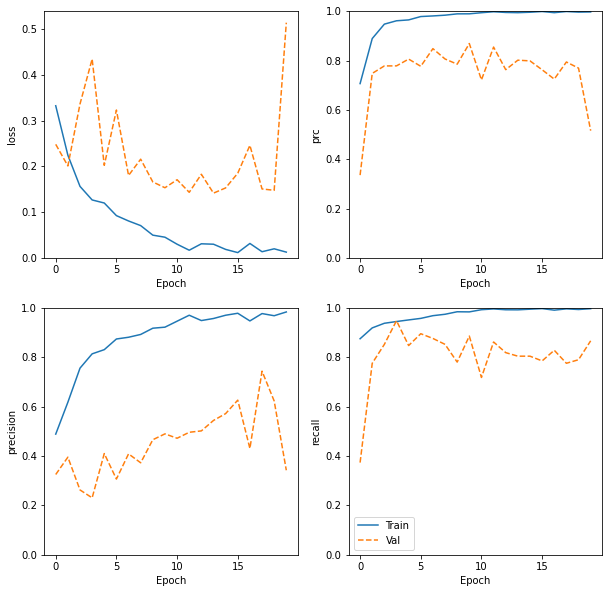

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3293
False Positives:  348
False Negatives:  28
True Positives:  181


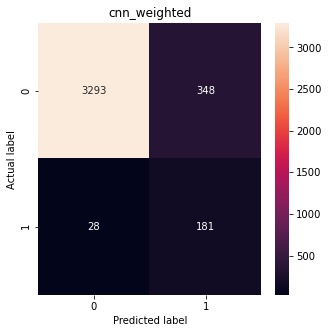

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'blue'
linestyles[name] = 'dotted'
plot_cm(labels[name], predictions[name], name)

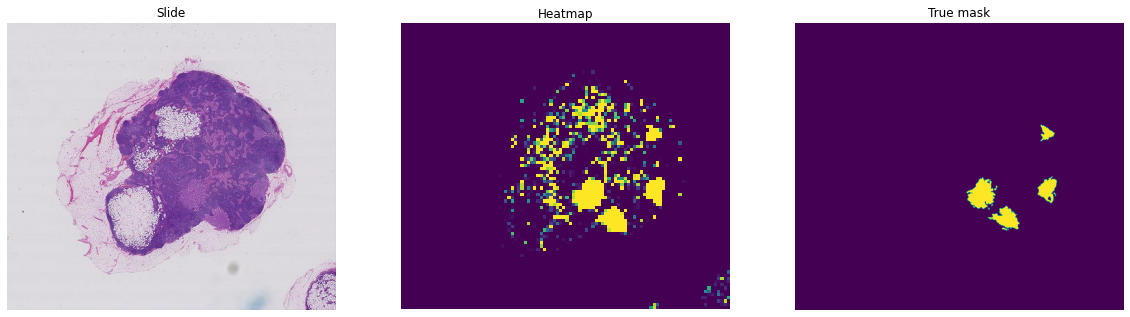

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

#### Upsampling the tumor class

In [ ]:
EPOCHS = 10
name = 'cnn_resampled'

if TRAIN_MODEL:
    model_base_resampled = make_base_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc', patience=7, restore_best_weights=True)
    history_base_resampled = model_base_resampled.fit(resampled_ds, validation_data=val_ds, epochs=EPOCHS, 
                                            steps_per_epoch=resampled_steps_per_epoch, callbacks=[callback]).history
    now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    save_model(model_base_resampled, name, LEVEL, EPOCHS)
    save_history(history_base_resampled, LEVEL, EPOCHS, name)

models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

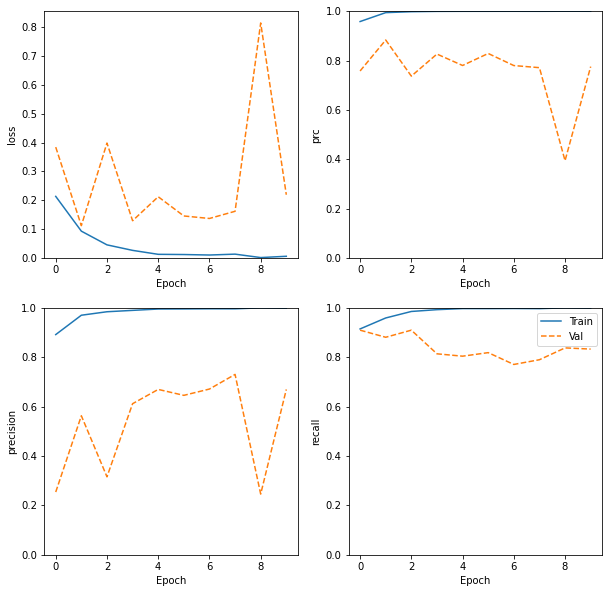

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3555
False Positives:  86
False Negatives:  35
True Positives:  174


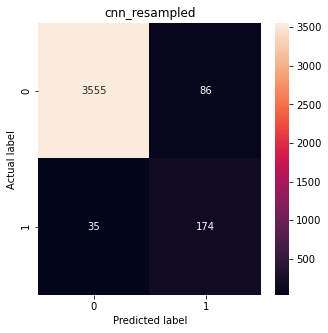

In [ ]:
predictions[name] = models[name].predict(val_ds)
labels[name] = lab_from_ds
linecolors[name] = 'blue'
linestyles[name] = '--'
plot_cm(labels[name], predictions[name], name)

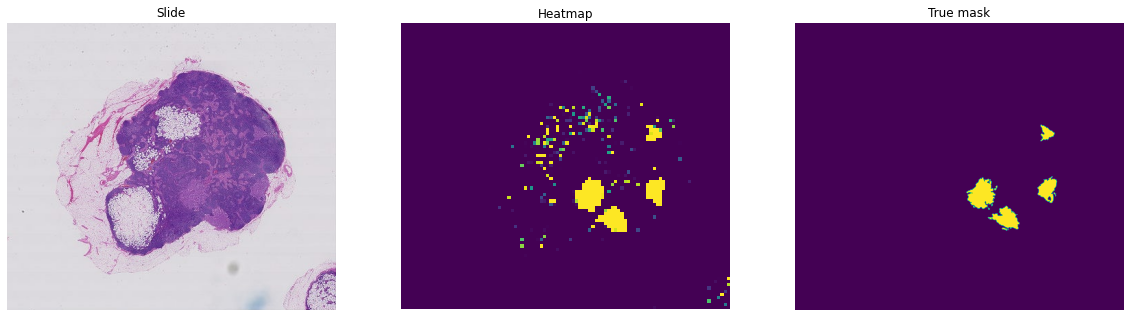

In [ ]:
display_heatmap(val_df, models[name], LEVEL, name)

## Multiple input model
The motivation of this multi-scale approach comes from the mentioned reference paper. For a patch at zoom level 1, we find patch at level 2 with centres aligned and pass them as parallel inputs to the model. The patches go through the same convolutional bases as in the previous model. The outputs of both the branches are then concatenated and fed to a single unit Dense layer for binary classifications.

To store data for this model, we save combined numpy arrays of the pair of patches in a .npy file (Shape [2,299,299,3]).

To generate train and validation datasets, we make use of generators with `tf.data.Dataset.from_generator` API. 

In [ ]:
multi_input_dir = os.path.join(project_folder, "multi_input")
if not os.path.exists(multi_input_dir):
    os.mkdir(multi_input_dir)

In [ ]:
def save_multi_inputs(slide, tumor_mask, save_dir, slide_number, level=LEVEL):
    tumor_dir = os.path.join(save_dir, "tumor")
    normal_dir = os.path.join(save_dir, "normal")
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(tumor_dir):
        os.mkdir(tumor_dir)
    if not os.path.exists(normal_dir):
        os.mkdir(normal_dir)
    
    print("Extracting patches from slide", slide_number)
    [width, height] = slide.level_dimensions[level]
    print("No. of patches", (height//PATCH_SIZE) * (width//PATCH_SIZE))
    count = 0
    seen = 0
    start = time.time()
    for y in range(0, height-PATCH_SIZE, PATCH_SIZE):
        for x in range(0, width-PATCH_SIZE, PATCH_SIZE):
            seen += 1
            if seen % 1000 == 0:
                print("{} patches seen. Time taken - {}s".format(seen, time.time() - start))
            
            im1 = read_slide(slide, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)
            tissue_pixels = find_tissue_pixels(im1)
            percent_tissue = len(tissue_pixels) / float(PATCH_SIZE * PATCH_SIZE) * 100
            if percent_tissue < tissue_threshold:
                continue
            mask = read_slide(tumor_mask, x*(2**level), y*(2**level), level, PATCH_SIZE, PATCH_SIZE)[:,:,0]
            tumor_pct = find_tumor_pixels(mask)
            dir = tumor_dir if tumor_pct > tumor_threshold else normal_dir
            
            (centre_x, centre_y) = (x+PATCH_SIZE//2, y+PATCH_SIZE//2)
            im2 = read_slide(slide, centre_x*(2**level) - (PATCH_SIZE//2)*2**(level+1), 
                         centre_y*(2**level) - (PATCH_SIZE//2)*2**(level+1), level+1, PATCH_SIZE, PATCH_SIZE)
            
            combined = np.array([im1, im2])
            np.save(os.path.join(dir, '{}_{}.npy'.format(slide_number, count)), combined)
            count += 1
    print("Finished extracting patches from slide {}. Total {} patches extracted".format(slide_number, count))

In [ ]:
if CREATE_DATA:
    for _,row in train_df.iterrows():
        slide_no = row['slide_no']
        slide_path = os.path.join(slide_dir, "tumor_{}.tif".format(str(slide_no).zfill(3)))
        mask_path = os.path.join(slide_dir, "tumor_{}_mask.tif".format(str(slide_no).zfill(3)))
        slide = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        save_multi_inputs(slide, tumor_mask, os.path.join(multi_input_dir, "train"), slide_no, level=LEVEL)
    for _,row in val_df.iterrows():
        slide_no = row['slide_no']
        slide_path = os.path.join(slide_dir, "tumor_{}.tif".format(str(slide_no).zfill(3)))
        mask_path = os.path.join(slide_dir, "tumor_{}_mask.tif".format(str(slide_no).zfill(3)))
        slide = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        save_multi_inputs(slide, tumor_mask, os.path.join(multi_input_dir, "val"), slide_no, level=LEVEL)

In [ ]:
# Training file paths
normal_dir = os.path.join(multi_input_dir, "train", "normal")
tumor_dir = os.path.join(multi_input_dir, "train", "tumor")
train_files = [os.path.join(normal_dir,f) for f in os.listdir(normal_dir)]
train_files.extend([os.path.join(tumor_dir,f) for f in os.listdir(tumor_dir)])
shuffle(train_files)

# Validation file paths
normal_dir = os.path.join(multi_input_dir, "val", "normal")
tumor_dir = os.path.join(multi_input_dir, "val", "tumor")
val_files = [os.path.join(normal_dir,f) for f in os.listdir(normal_dir)]
val_files.extend([os.path.join(tumor_dir,f) for f in os.listdir(tumor_dir)])
shuffle(val_files)

In [ ]:
def load_np(filepath):
    combined = np.load(filepath)
    im1,im2 = combined[0], combined[1]
    label = 0 if "normal" in filepath else 1
    return im1, im2, label

#### Defining training and validation data generators

Note that we did not apply shuffle to `val_generator` so that we can use it for predictions and analyzing the results.

In [ ]:
def train_generator():
    def generator():
        for f in train_files:
            im1, im2, label = load_np(f)
            yield (im1, im2), label

    types = ((tf.uint8, tf.uint8), tf.int64)
    shapes = (([PATCH_SIZE, PATCH_SIZE, 3], [PATCH_SIZE, PATCH_SIZE, 3]), ())
    dataset = tf.data.Dataset.from_generator(generator, output_types=types, output_shapes=shapes)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def val_generator():
    def generator():
        for f in val_files:
            im1, im2, label = load_np(f)
            yield (im1, im2), label

    types = ((tf.uint8, tf.uint8), tf.int64)
    shapes = (([PATCH_SIZE, PATCH_SIZE, 3], [PATCH_SIZE, PATCH_SIZE, 3]), ())
    dataset = tf.data.Dataset.from_generator(generator, output_types=types, output_shapes=shapes)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

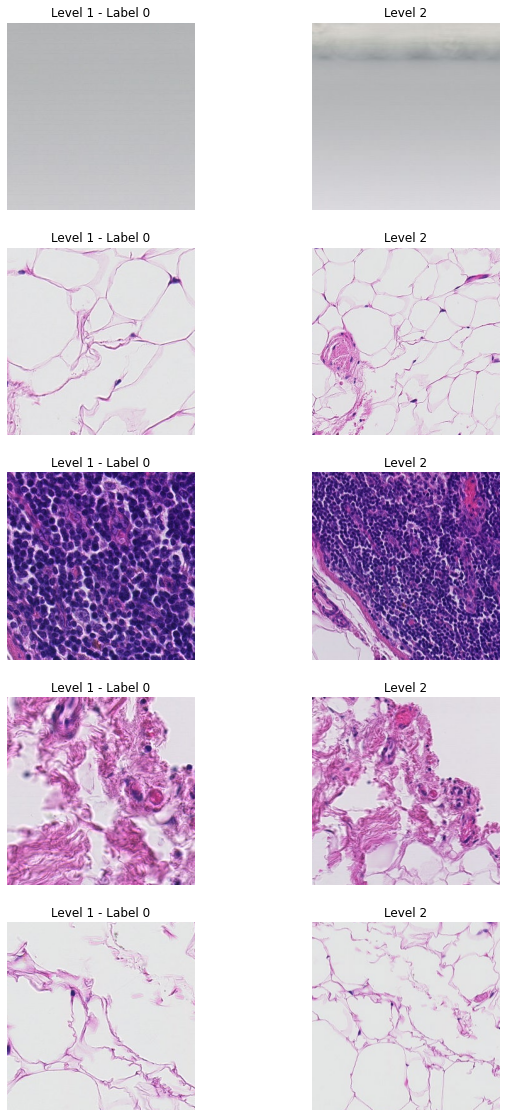

In [ ]:
for (im1,im2),y in train_generator().take(1):
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
    for i in range(5):
        ax[i,0].axis('off')
        ax[i,0].imshow(im1[i])
        ax[i,0].set_title('Level 1 - Label {}'.format(y[i]))
        ax[i,1].axis('off')
        ax[i,1].imshow(im2[i])
        ax[i,1].set_title('Level 2')

In [ ]:
def get_cnn_base(name):
    return Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
    ], name=name)

In [ ]:
def make_multi_model():

    img_input1 = Input(shape=(PATCH_SIZE, PATCH_SIZE, 3), name='im1_input')  ## branch 1 with image input
    out_a = get_cnn_base("base_cnn1")(img_input1)

    img_input2 = Input(shape=(PATCH_SIZE, PATCH_SIZE, 3), name='im2_input')  ## branch 2 with image input
    out_b = get_cnn_base("base_cnn2")(img_input2)

    concatenated = concatenate([out_a, out_b])    ## concatenate the two branches
    out = Dense(1, activation='sigmoid')(concatenated)

    model = Model([img_input1, img_input2], out)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[METRICS])
    return model

In [ ]:
EPOCHS = 10
name = 'multiple_input'

if TRAIN_MODEL:
    model_multi = make_multi_model()
    history_multi = model_multi.fit(train_generator(), validation_data=val_generator(), epochs=EPOCHS).history
    save_model(model_multi, name, LEVEL, EPOCHS)
    save_history(history_multi, LEVEL, EPOCHS, name)

models[name] = load_model(name, LEVEL, EPOCHS)
histories[name] = load_history(LEVEL, EPOCHS, name)

In [ ]:
models[name].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
im1_input (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
im2_input (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
base_cnn1 (Sequential)          (None, 64)           1387680     im1_input[0][0]                  
__________________________________________________________________________________________________
base_cnn2 (Sequential)          (None, 64)           1387680     im2_input[0][0]                  
____________________________________________________________________________________________

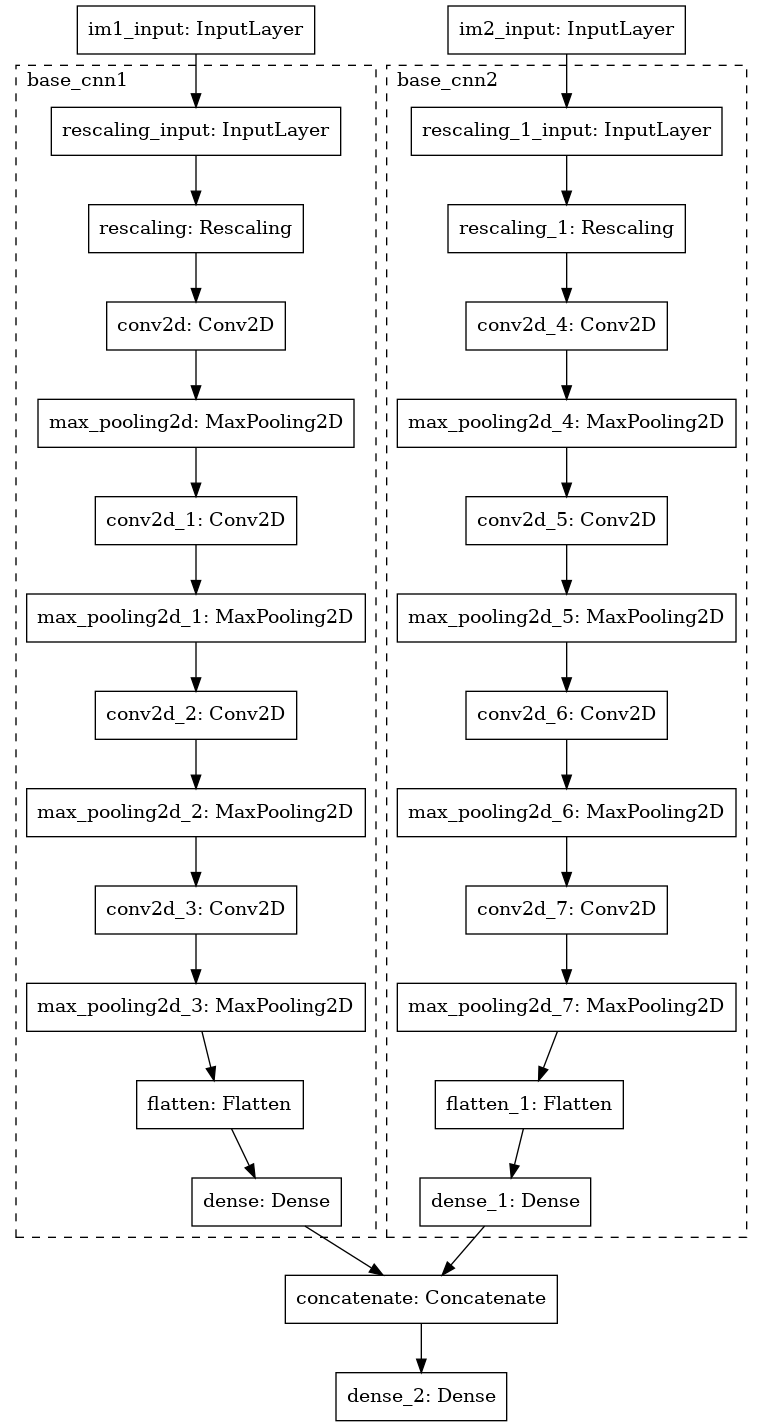

In [ ]:
plot_model(make_multi_model(), expand_nested=True)

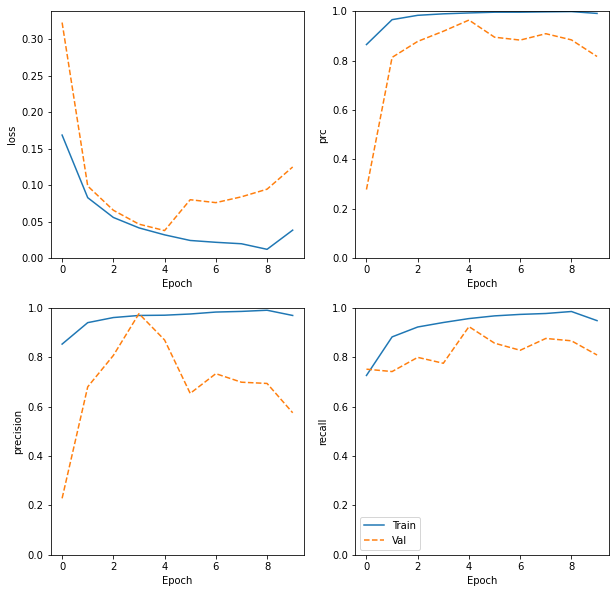

In [ ]:
plot_metrics(histories[name], EPOCHS)

True Negatives:  3516
False Positives:  125
False Negatives:  40
True Positives:  169


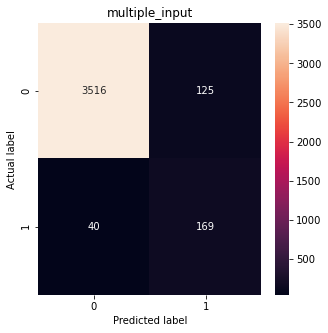

In [ ]:
predictions[name] = models[name].predict(val_generator())
labels[name] = list(val_generator().flat_map(lambda x,y: tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator())
linecolors[name] = 'yellow'
linestyles[name] = '-'
plot_cm(labels[name], predictions[name], name)

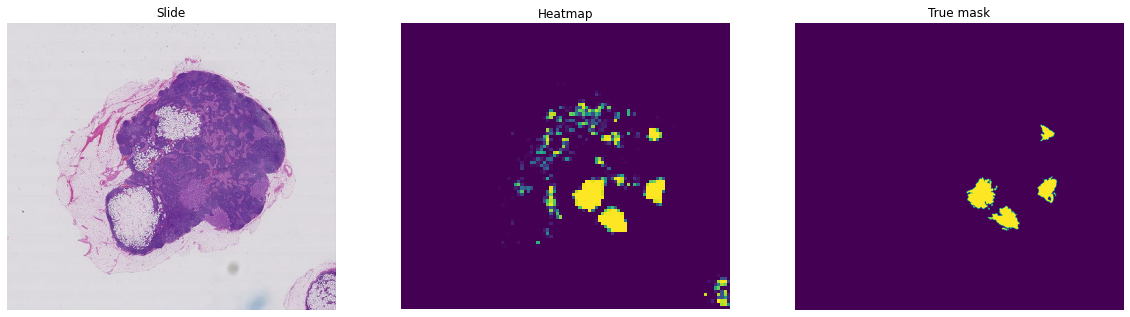

In [ ]:
display_heatmap(val_df, models[name], LEVEL, model_name=name, multi_input=True)

## Comparing the different models

We have trained 7 different models - 
1. transfer_base - Transfer learning 
2. transfer_weighted - Transfer learning with weighted classes
3. transfer_resampled - Transfer learning with upsampling of tumor class
4. cnn_base - Deep CNN model defined by us
5. cnn_weighted - Deep CNN model with weighted classes
6. cnn_resampled - Deep CNN model with upsampling of tumor class
7. multiple_input - Model taking a pair of images as input (at different zoom levels)

Next, we analyze our results and compare these models on different evaluation metrics.



### F1-score

In [ ]:
evaluations = {}
for name in models:
    cm = confusion_matrix(labels[name], predictions[name]>0.5)
    eval_dict = {'True negatives':cm[0][0], 
                 'False positives':cm[0][1], 
                 'False negatives':cm[1][0], 
                 'True positives':cm[1][1],
                'F1 score':f1_score(labels[name], predictions[name]>0.5)}
    evaluations[name] = eval_dict
pd.DataFrame(evaluations).T.sort_values('F1 score')

### Plotting the ROC curve

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

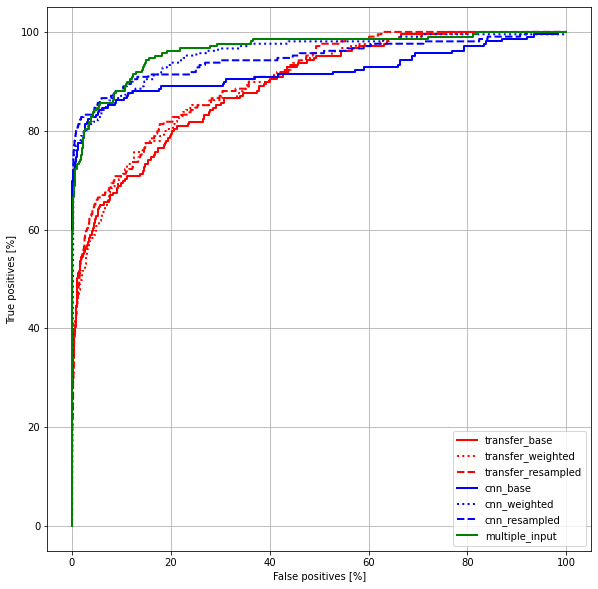

In [ ]:
plt.figure(figsize=(10,10))
for name in models:
    plot_roc(name, labels[name], predictions[name], linestyle=linestyles[name], color=linecolors[name])
plt.legend(loc='lower right')

### Plotting Precision-Recall curve

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

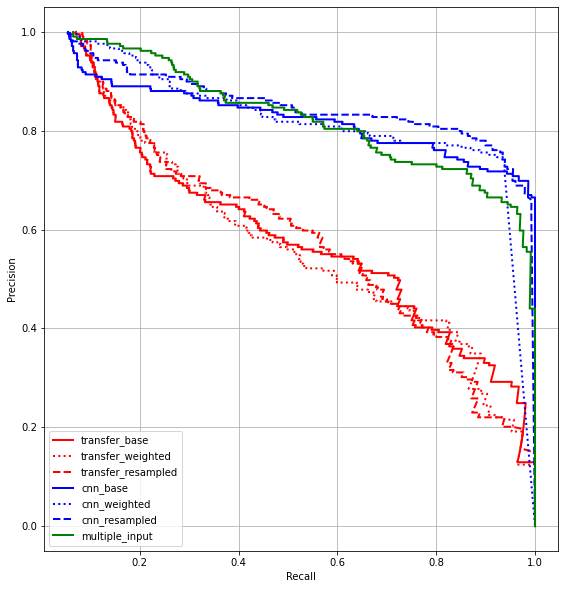

In [ ]:
plt.figure(figsize=(10,10))
for name in models:
    plot_prc(name, labels[name], predictions[name], linestyle=linestyles[name], color=linecolors[name])
plt.legend(loc='lower left')

### Intersection over Union

In [ ]:
def plot_iou(name, labels, predictions, **kwargs):
    iou = []
    p_values = np.linspace(0,1,50)
    for p in p_values:
        m = tf.keras.metrics.MeanIoU(num_classes=2)
        m.update_state(labels, predictions>p)
        iou.append(m.result().numpy())
    iou = np.array(iou)
    plt.plot(100*p_values, 100*iou, label=name, linewidth=2, **kwargs)
    plt.xlabel('p value')
    plt.ylabel('IoU score')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

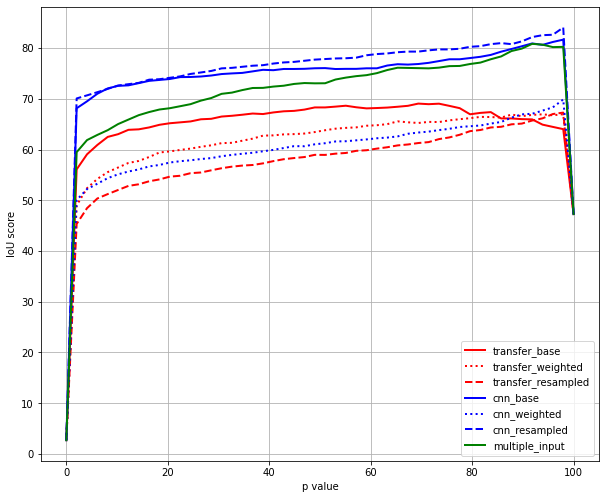

In [ ]:
plt.figure(figsize=(10,10))
for name in models:
    plot_iou(name, labels[name], predictions[name], linestyle=linestyles[name], color=linecolors[name])
plt.legend(loc='lower right')

### Another look at the heatmaps generated by all the individual models

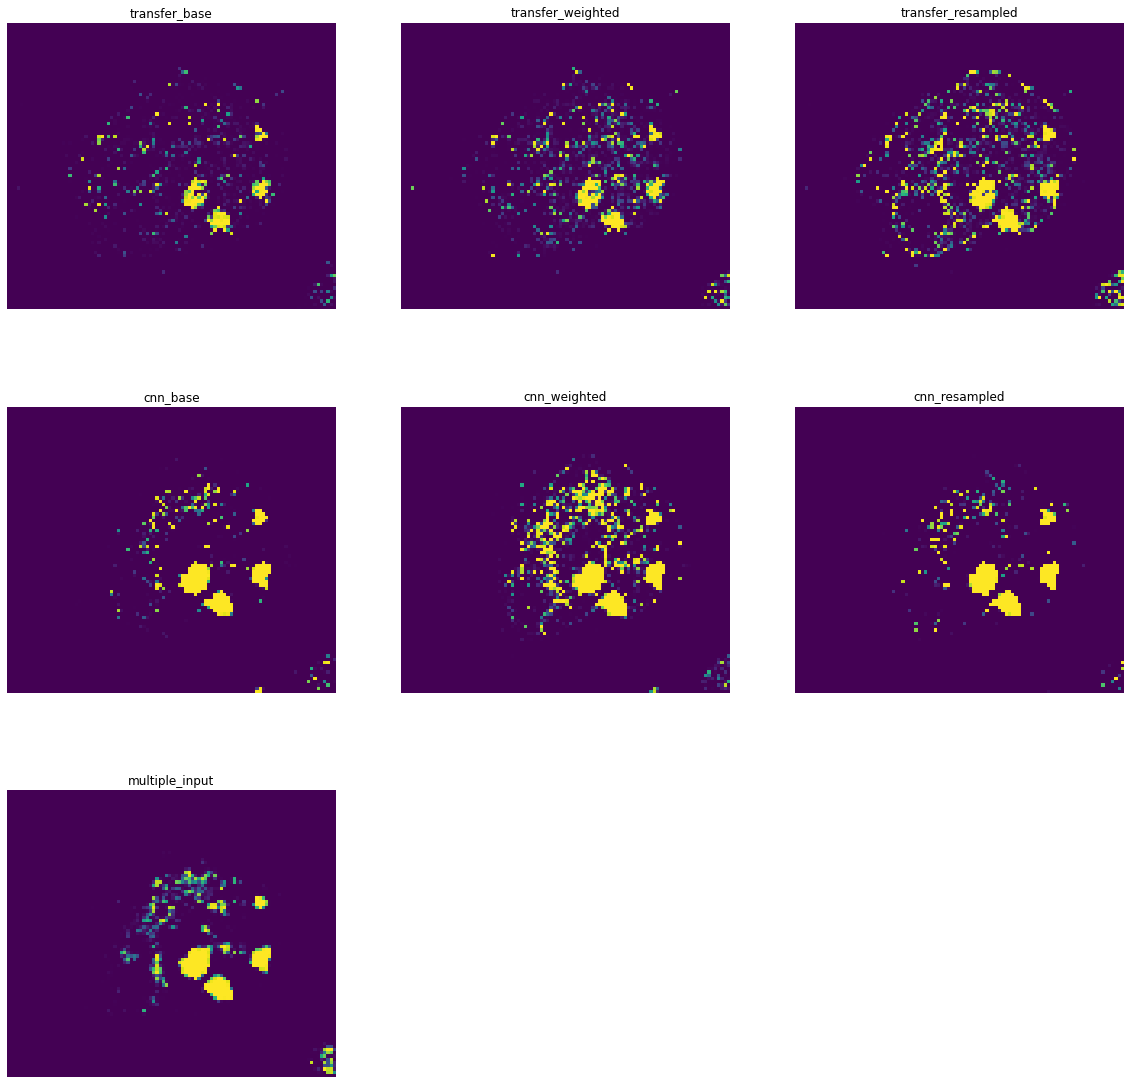

In [ ]:
plt.figure(figsize=(20,20))
i = 1
for name in models:
    ax = plt.subplot(3,3,i)
    im = Image.open(os.path.join(project_folder, "heatmaps", name+".PNG"))
    plt.imshow(im)
    plt.axis('off')
    plt.title(name)
    i += 1

## Observations

* Transfer learning is not helpful at all in this case. This is because we are using weights trained on imagenet data, which includes natural and real world objects, which are quite different from tissue cells.
* Handling data imbalance with simple techniques tried above is not very effective, especially if we sample data from both the classes equally, which is actually not representative of the real data.
* Using multiple input model with slides of zoom level 1 and 2 gives results almost same as the base CNN model with slides of zoom level 1. This is in resonance with the results from the referenced paper.


## Trying out level zero slides

In [ ]:
LEVEL = 0

data_dir = os.path.join(project_folder, "level_{}".format(LEVEL))
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [ ]:
train_ds_l0 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred'
)

val_ds_l0 = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=False
)

Found 88273 files belonging to 2 classes.
Found 15143 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_l0 = train_ds_l0.prefetch(buffer_size=AUTOTUNE)
val_ds_l0 = val_ds_l0.prefetch(buffer_size=AUTOTUNE)

In [ ]:
EPOCHS = 5
name = "l0_cnn"
if TRAIN_MODEL:
    model = make_base_model()
    history = model.fit(train_ds_l0, validation_data=val_ds_l0, epochs=EPOCHS).history
    save_model(model, name, LEVEL, EPOCHS)
    save_history(history, LEVEL, EPOCHS, name)
model_l0 = load_model(name, LEVEL, EPOCHS)
history_l0 = load_history(LEVEL, EPOCHS, name)

In [ ]:
labels_l0 = list(val_ds_l0.flat_map(lambda x,y: tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator())
predictions_l0 = model_l0.predict(val_ds_l0)

True Negatives:  13467
False Positives:  983
False Negatives:  88
True Positives:  605


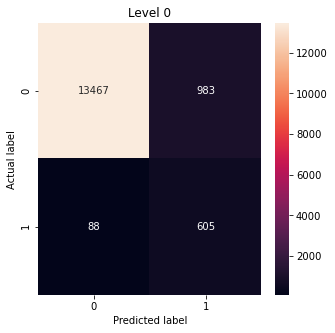

In [ ]:
plot_cm(labels_l0, predictions_l0, "Level 0")

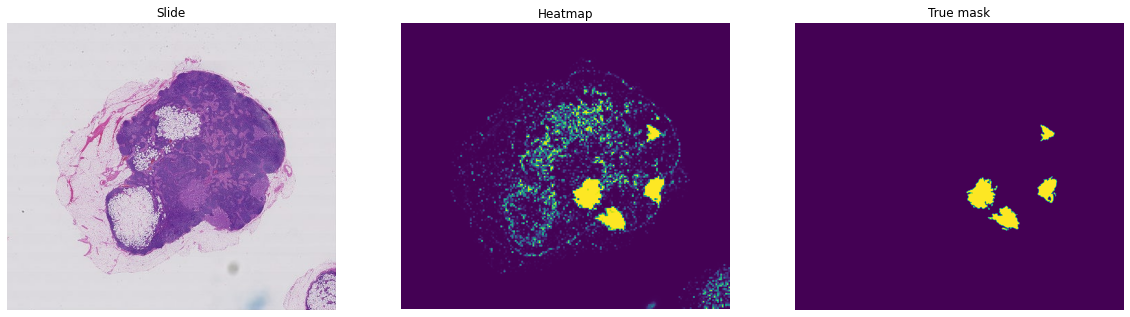

In [ ]:
display_heatmap(val_df, model_l0, 0)

In [ ]:
LEVEL = 1

## Generating all heatmaps

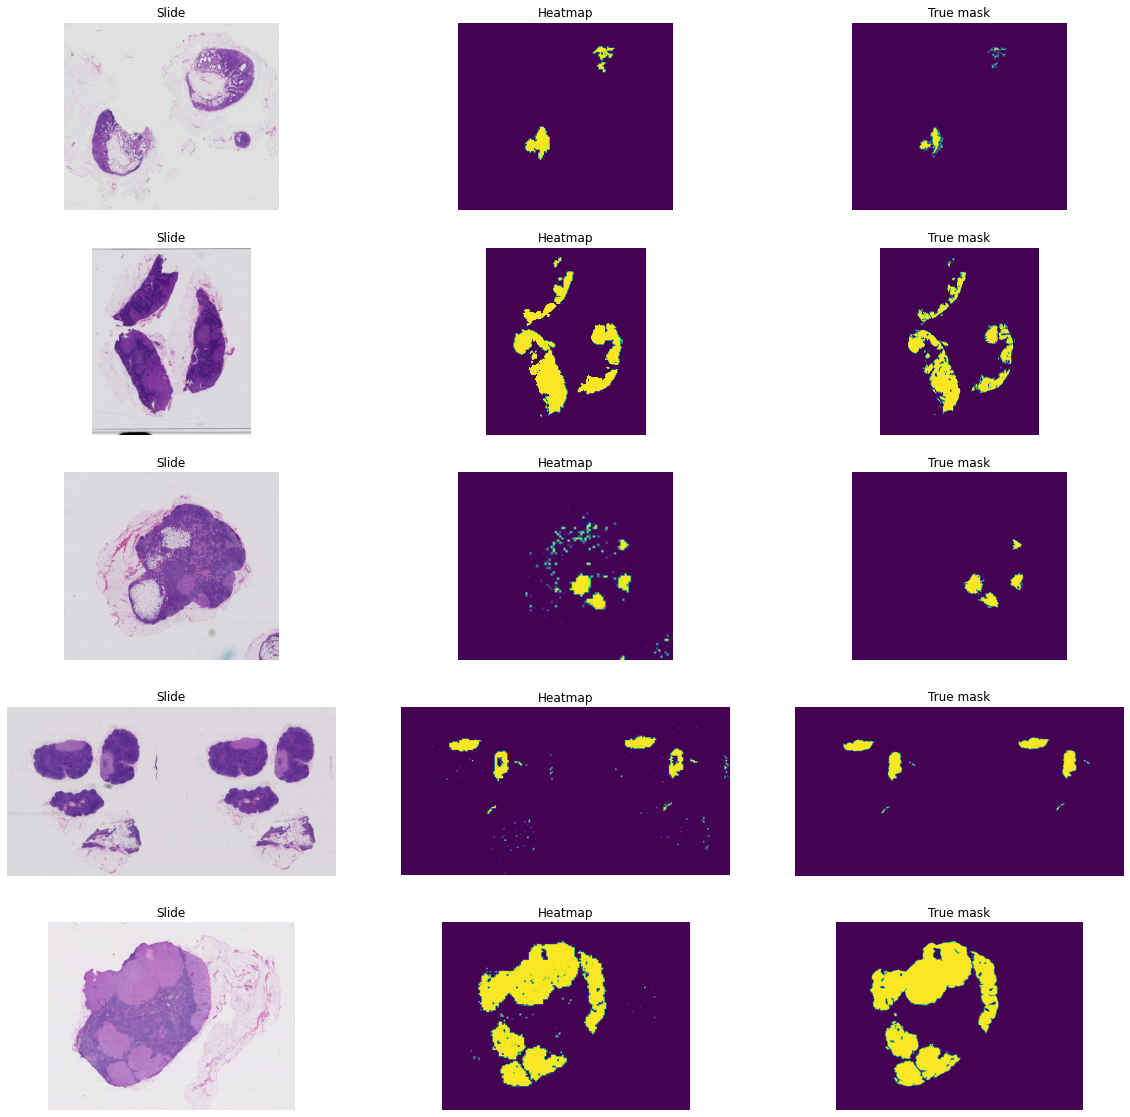

In [ ]:
hm = display_heatmap(df, models['cnn_base'], LEVEL)

## Further possible improvements
* Using a more sophisticated technique to handle data imbalance. Instead of 50/50 sampling, we can try with different ratios to resample the data.
* With more time and computing power, training on level zero slides is expected to give much improved results.
* Comparing a level 1 base CNN model with a level2 and level 3 multiple input model. If the results improve or are comparable, we would be optimizing the solution by using much lesser data.